# LastFM Popularity

<b>What</b> are the most popular music genres in LastFM? <b>Who</b> are the most popular artists in each genre, and <b>where</b> do they come from? <br>
<b>When</b> the music was made? <b>What</b> are their mood?

These are the questions that these project makes. We will levarege the [dataset](https://www.kaggle.com/pieca111/music-artists-popularity) made available in Kaggle by [Piotr](https://www.kaggle.com/pieca111) to answer them.

### Lets take a look at the dataset.

In [492]:
import pandas as pd

df = pd.read_csv(
    'Datasets/artists.csv',
    dtype=dict(
        artist_lastfm=str, 
        country_lastfm=str, 
        tags_lastfm=str
        )
    )

df.head(1)

,mbid,artist_mb,artist_lastfm,country_mb,country_lastfm,tags_mb,tags_lastfm,listeners_lastfm,scrobbles_lastfm,ambiguous_artist
0,cc197bad-dc9c-440d-a5b5-d52ba2e14234,Coldplay,Coldplay,United Kingdom,United Kingdom,rock; pop; alternative rock; british; uk; brit...,rock; alternative; britpop; alternative rock; ...,5381567.0,360111850.0,False


To answer the questions we posed at the beginning, we will need:<br>
- <b>ambiguous_artist</b> | Sometimes more than one artist may share the same name
- <b>artist_lastfm</b> | Artist name in LastFM
- <b>country_lastfm</b> | Their countries
- <b>tags_lastfm</b> | Their tags
- <b>listeners_lastfm</b> | You get the idea.
- <b>scrobbles_lastfm</b>




In [493]:
df = df[['ambiguous_artist', 'artist_lastfm', 'country_lastfm', 'tags_lastfm', 'listeners_lastfm', 'scrobbles_lastfm']]
df.head()

,ambiguous_artist,artist_lastfm,country_lastfm,tags_lastfm,listeners_lastfm,scrobbles_lastfm
0,False,Coldplay,United Kingdom,rock; alternative; britpop; alternative rock; ...,5381567.0,360111850.0
1,False,Radiohead,United Kingdom,alternative; alternative rock; rock; indie; el...,4732528.0,499548797.0
2,False,Red Hot Chili Peppers,United States,rock; alternative rock; alternative; Funk Rock...,4620835.0,293784041.0
3,False,Rihanna,Barbados; United States,pop; rnb; female vocalists; dance; Hip-Hop; Ri...,4558193.0,199248986.0
4,False,Eminem,United States,rap; Hip-Hop; Eminem; hip hop; pop; american; ...,4517997.0,199507511.0


Way better.
### <b>However</b>

In [494]:
df.tail()

,ambiguous_artist,artist_lastfm,country_lastfm,tags_lastfm,listeners_lastfm,scrobbles_lastfm
1466078,False,NaN,South Korea,NaN,NaN,NaN
1466079,False,NaN,NaN,NaN,NaN,NaN
1466080,False,NaN,NaN,NaN,NaN,NaN
1466081,False,NaN,South Korea,NaN,NaN,NaN
1466082,False,NaN,South Korea,NaN,NaN,NaN


Looks like we have our fair share of null values

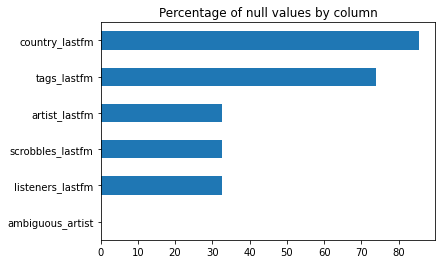

In [495]:
null_rate = (df.isna().sum() / len(df)) * 100

ax = (
    null_rate
    .sort_values()
    .plot.barh(title='Percentage of null values by column')
    )

The column with the highest number of null values is country_lastfm, with a <b>null rate of approximately 85%</b>. <br>

It might reasonable to assume that the artists with no country filled in their lastfm page should not be among the most popular. Lets drop all null values and check how many plays we lose

In [496]:
print('Total scrobbles (plays) before filtering null values:')
print(f'{df["scrobbles_lastfm"].sum():,}')

df.dropna(axis=0, how='any', inplace=True)

print('...and after:')
print(f'{df["scrobbles_lastfm"].sum():,}')

Total scrobbles (plays) before filtering null values:
120,324,972,038.0
...and after:
102,827,413,080.0


So we are losing less than 20% of the total plays by doing so.<br><br>
Now, lets see how much we lose by dropping the ambiguous artists

In [497]:
df.drop(df[df['ambiguous_artist']].index, inplace=True)
df.drop(df[df['scrobbles_lastfm'] <= 0].index, inplace=True) # lets drop artists with no plays as well

print('Total number of plays:' ,f'{df["scrobbles_lastfm"].sum():,}')
print('Total number of unique artists:' ,f'{len(df):,}')

Total number of plays: 87,214,810,301.0
Total number of unique artists: 171,128


So we are set with 3/4 of the original number of plays and with over 170 thousand unique artists. That will do. <br><br>
Some standard dataprep:

In [498]:
df.drop(['ambiguous_artist'], axis=1, inplace=True) # We don't need this column anymore
df.columns = ['artist', 'country', 'tags','listeners', 'scrobbles'] # If not at the sacrifice of clarity, shorter names = good
df[['scrobbles', 'listeners']] = df[['scrobbles', 'listeners']].astype(int) # There are no half listeners (nor half scrobble)
df.sort_values(by='scrobbles', ascending=False, inplace=True)

df.head()

,artist,country,tags,listeners,scrobbles
17,The Beatles,United Kingdom,classic rock; rock; british; 60s; pop,3674017,517126254
1,Radiohead,United Kingdom,alternative; alternative rock; rock; indie; el...,4732528,499548797
0,Coldplay,United Kingdom,rock; alternative; britpop; alternative rock; ...,5381567,360111850
8,Muse,United Kingdom,alternative rock; rock; alternative; Progressi...,4089612,344838631
23,Arctic Monkeys,United Kingdom,indie rock; indie; british; rock; alternative;...,3501680,332306552


### We could really use these tags, if only they were each in their own row....

In [499]:
df['tags'] = df['tags'].apply(lambda x: x.split('; '))
df['country'] = df['country'].apply(lambda x: x.split('; ')) # Some gorups have members from multiple countries

df = df.explode('tags')
df = df.explode('country')

df.reset_index(inplace=True, drop=True)
df.head()

,artist,country,tags,listeners,scrobbles
0,The Beatles,United Kingdom,classic rock,3674017,517126254
1,The Beatles,United Kingdom,rock,3674017,517126254
2,The Beatles,United Kingdom,british,3674017,517126254
3,The Beatles,United Kingdom,60s,3674017,517126254
4,The Beatles,United Kingdom,pop,3674017,517126254


### There you go.

In [500]:
tags = df.groupby(by='tags').size().sort_values(ascending=False)
print(f'{len(tags):,}')

323,038


We have <b>323,038</b> unique tags.

<b>Which is quite a lot.</b> <br>
<br>
Lets take a look at them

In [501]:
print(tags.index[:50])

Index(['seen live', 'rock', 'electronic', 'pop', 'All', 'indie', 'alternative',
       'female vocalists', 'under 2000 listeners', 'experimental', 'american',
       'folk', 'metal', 'punk', 'male vocalists', 'electronica', 'ambient',
       'spotify', 'USA', 'jazz', 'singer-songwriter', 'instrumental',
       'hardcore', '00s', 'dance', 'alternative rock', 'indie rock', 'german',
       'japanese', 'british', 'Hip-Hop', 'punk rock', '90s', 'psychedelic',
       'electro', 'world', '80s', 'chillout', 'death metal', 'acoustic',
       'french', 'black metal', 'rap', 'indie pop', 'female vocalist',
       'hard rock', 'hip hop', 'techno', 'heavy metal', 'soul'],
      dtype='object', name='tags')


### Warning! Arbitraty decisions below
# EXPLAIN
- Musical genre
- Mood
- Decade

In [502]:
from tag_flagger import tag_flagger_machine

In [503]:
tag_flagger_machine(tags.index, start_index=830)

 
 --------------------        
 1 = genre        
 2 = mood        
 3 = instrument        
 r = tag name did not display: reload        
 x = exit program        
 anything else = dump        
 -------------------- 
 Tag: dance pop
Tags 830 to 830 have been successfully classified!


{'genre': {'values': [], 'message': ' -> genre'},
 'mood': {'values': [], 'message': ' -> mood'},
 'instrument': {'values': [], 'message': ' -> instrument'}}

In [504]:
tags_csv_path = f'Datasets\\tags_classification\\'
tags_csv_dir = os.listdir(tags_csv_path)
df_tags = pd.DataFrame(columns=['tag_category', 'tags'])

for file in my_dir:
    if '.csv' in file:
        df_temp = pd.read_csv(tags_csv_path + file, delimiter=';', index_col=0, names=['tag_category', 'tags'])
        df_tags = pd.concat([df_tags, df_temp], ignore_index=True)

### Was this genre more active in the 60s or the 70s?
Lets add a few tags manually so we can answer this question later

In [505]:
df_decades = pd.DataFrame(data={'tags': ['40s', '50s', '60s', '70s', '80s', '90s', '00s', '10s']})
df_decades['tag_category'] = 'decade'
df_tags = df_tags.append(df_decades)

df_tags.tail()

,tag_category,tags
3,decade,70s
4,decade,80s
5,decade,90s
6,decade,00s
7,decade,10s


### It looks like some tags can be written in more than one way...

In [506]:
df_tags[(df_tags['tags'] == "rock'n'roll") | (df_tags['tags'] == 'rock n roll')]

,tag_category,tags
75,genre,rock'n'roll
180,genre,rock n roll


In this case if we removed empty spaces and the ' character we would be able to map both instanced of Rock'n'Roll tag to the same value

In [507]:
df_tags['tag_clean'] = df_tags['tags'].str.upper()

(df_tags['tag_clean']
    .replace(['&', 'AND'], 'N',
    regex=True, inplace=True))

(df_tags['tag_clean']
    .replace(["'", ' ', '-'], '',
    regex=True, inplace=True))
    
df_tags['tag_clean'][:20].values

array(['METAL', 'PUNK', 'JAZZ', 'HARDCORE', 'ALTERNATIVEROCK',
       'INDIEROCK', 'PUNKROCK', 'ELECTRO', 'CHILLOUT', 'DEATHMETAL',
       'BLACKMETAL', 'RAP', 'INDIEPOP', 'HARDROCK', 'HIPHOP', 'TECHNO',
       'HEAVYMETAL', 'SOUL', 'HOUSE', 'PROGRESSIVEROCK'], dtype=object)

How many duplicate tags were we able to map?

In [508]:
print('Unique tags before cleaning:', len(df_tags))
print('Unique tags after cleaning: ', len(df_tags.drop_duplicates(subset='tag_clean')))

Unique tags before cleaning: 245
Unique tags after cleaning:  215


So we got rid of 30 duplicate tags<br>
We will match all variations of a given genre to the way it was written in its first appearence

In [509]:
tags_to_keep_series = df_tags.groupby('tag_clean')['tags'].first()
df_tags['tag_to_keep'] = df_tags['tag_clean'].map(tags_to_keep_series)
df_tags[df_tags['tag_clean'] == 'ROCKNROLL']

,tag_category,tags,tag_clean,tag_to_keep
75,genre,rock'n'roll,ROCKNROLL,rock'n'roll
180,genre,rock n roll,ROCKNROLL,rock'n'roll
186,genre,Rock and Roll,ROCKNROLL,rock'n'roll


Its time to bring out tags selection, mapping and classification to the main dataframe  

In [510]:
# I'm not using inner join to filter because it sorts the dataset and we will leverage the tag order soon
df = df.merge(df_tags[['tags', 'tag_to_keep', 'tag_category']],
            on='tags', how='left')
df.dropna(subset=['tag_to_keep'], inplace=True)

df.drop(columns='tags', inplace=True)

df = df[['artist', 'country', 'tag_category', 'tag_to_keep', 'listeners', 'scrobbles']]
df.columns = ['artist', 'country', 'tag_category', 'tags', 'listeners', 'scrobbles']

We don't need two tags telling me that Led Zeppelin is Rock'n'Roll

In [511]:
df[(df['tags'] == "rock'n'roll") & (df['artist'] == 'Led Zeppelin')]

,artist,country,tag_category,tags,listeners,scrobbles
900,Led Zeppelin,United Kingdom,genre,rock'n'roll,2930957,188306100
907,Led Zeppelin,United Kingdom,genre,rock'n'roll,2930957,188306100


In [512]:
df.drop_duplicates(subset=['artist', 'country', 'tags'], inplace=True)
df[(df['tags'] == "rock'n'roll") & (df['artist'] == 'Led Zeppelin')]

,artist,country,tag_category,tags,listeners,scrobbles
900,Led Zeppelin,United Kingdom,genre,rock'n'roll,2930957,188306100


### But...
We still have an issue to solve.<br>
Lets take a look at all the genres that we are currently assigning to <b>Radiohead<b/>

In [513]:
df[(df['artist']=='Radiohead') & (df['tag_category']=='genre')][['artist', 'tags']]

,artist,tags
6,Radiohead,alternative rock
12,Radiohead,britpop
13,Radiohead,indie rock
16,Radiohead,Progressive rock
20,Radiohead,Experimental Rock
21,Radiohead,post-rock
34,Radiohead,chillout
37,Radiohead,indie pop
38,Radiohead,trip-hop
40,Radiohead,classic rock


They might have a few songs that can be understood as chillout, but this is by no means their genre. So as to avoid having Radiohead as the most listened chillout artist, we will select only the <b>top 3 genres per artist</b>.
<br>
<br>
I'm not sure how lastfm ranks them, but they are certainly ranked by relevance (probably by the number of users that set each tag to an artist)



In [514]:
df_genres = df[df['tag_category'] == 'genre']
df['tag_order'] = df_genres.groupby('artist').cumcount() + 1
df['tag_order'] = df['tag_order'].fillna(1).astype(int)
df = df[df['tag_order'] < 4]
df.drop(columns='tag_order', inplace=True)

df[(df['artist']=='Radiohead') & (df['tag_category']=='genre')][['artist', 'tags']]


,artist,tags
6,Radiohead,alternative rock
12,Radiohead,britpop
13,Radiohead,indie rock


Way better. <br>

### But we need to be wary...<br> 
...of duplicating values when aggregating. <br>

Each artist appears in more than one row:

In [515]:
df.head(2)

,artist,country,tag_category,tags,listeners,scrobbles
0,The Beatles,United Kingdom,genre,classic rock,3674017,517126254
3,The Beatles,United Kingdom,decade,60s,3674017,517126254


So if we sum over an artist we end up multiplying its listeners and play count by the number of rows that it appears.

In [516]:
df.groupby('artist').sum().loc['The Beatles']

listeners    7.348034e+06
scrobbles    1.034253e+09
Name: The Beatles, dtype: float64

### We can handle that in Tableau... <br>
... by using aggregations such as "MAX". But that will require <b>Tableau to calculate it over and over again</b>.<br>
We can lend a hand to Tableau by creating boolean columns identifying unique rows.<br> <br>
We have increased the number of rows in our dataframe two times:

- When we expanded the <b>tags</b>
- and when we expanded the <b>countries</b>  <br>

We will start by creating a row count for each <b>artist</b> and each combination of <b>artist-tag</b> and <b>artist-country</b>

In [517]:
df['artist_unique'] =  df.groupby(['artist']).cumcount() + 1
df['tags_artist_unique'] = df.groupby(['artist', 'tags']).cumcount() + 1
df['country_artist_unique'] = df.groupby(['artist', 'country']).cumcount() + 1
df.head()

,artist,country,tag_category,tags,listeners,scrobbles,artist_unique,tags_artist_unique,country_artist_unique
0,The Beatles,United Kingdom,genre,classic rock,3674017,517126254,1,1,1
3,The Beatles,United Kingdom,decade,60s,3674017,517126254,2,1,2
6,Radiohead,United Kingdom,genre,alternative rock,4732528,499548797,1,1,1
12,Radiohead,United Kingdom,genre,britpop,4732528,499548797,2,1,2
13,Radiohead,United Kingdom,genre,indie rock,4732528,499548797,3,1,3


And then flagging as <b>True</b> where the value is one

In [518]:
cols_to_bool = ['artist_unique', 'tags_artist_unique', 'country_artist_unique']

for col in cols_to_bool:
    df[col] = df[col].apply(lambda x: x==1)
    
df.head()

,artist,country,tag_category,tags,listeners,scrobbles,artist_unique,tags_artist_unique,country_artist_unique
0,The Beatles,United Kingdom,genre,classic rock,3674017,517126254,True,True,True
3,The Beatles,United Kingdom,decade,60s,3674017,517126254,False,True,False
6,Radiohead,United Kingdom,genre,alternative rock,4732528,499548797,True,True,True
12,Radiohead,United Kingdom,genre,britpop,4732528,499548797,False,True,False
13,Radiohead,United Kingdom,genre,indie rock,4732528,499548797,False,True,False


### It would be handy to have an artist rank by tag already in place

In [519]:
df.sort_values(by=['tags', 'scrobbles'], ascending=False, inplace=True)
df['artist_rank_by_tag'] = df.groupby(by=['tags'])['scrobbles'].rank(method='dense', ascending=False).astype(int)

# Top 5 artists in rock'n'roll
df[df['tags'] == "rock'n'roll"][['artist', 'scrobbles']][:5]

,artist,scrobbles
5915,Elvis Presley,71070448
8105,Creedence Clearwater Revival,59206227
14293,John Lennon,37233044
36310,Chuck Berry,16860769
50044,Roy Orbison,12383506


# That's all


In [520]:
df['tags'] = df['tags'].str.capitalize() # better keep capitalization consistent
df.to_csv('Datasets/lastfm_tags.csv', index=False)